In [63]:
from dotenv import load_dotenv
load_dotenv()

True

# Notion Client Setup

In [20]:
# Initialize Notion client from a static API key
from notion_client import Client

import os
auth_token = os.getenv("NOTION_API_KEY")
notion = Client(auth=auth_token)


In [ ]:
# List comments on a particular block
# target_block = '3730594e-7b81-45db-ba04-55047f89e342'
target_block = os.getenv("NOTION_PAGE")
comments = notion.comments.list(block_id=target_block).get("results", [])
comments

## Using an authorized user from supabase

In [11]:
from supabase import create_client, Client

import os

url: str = os.getenv("SUPABASE_URL")
key: str = os.getenv("SUPABASE_SERVICE_ROLE_KEY")

supabase: Client = create_client(
    supabase_url=url,
    supabase_key=key, 
    options=ClientOptions(auto_refresh_token=False, persist_session=False)
)

authenticated_user = supabase.table("subscriptions").select("user_id").eq("notion_user_id", "59164cd3-f8de-49dc-a432-e8cb48b4a39d").execute()
print(authenticated_user.data)

[{'user_id': '6f7b0ac6-dcbd-4bec-ad35-40feac2ef86e'}]


In [ ]:
response = supabase.auth.admin.get_user_by_id('6f7b0ac6-dcbd-4bec-ad35-40feac2ef86e')
response

AttributeError: 'NoneType' object has no attribute 'user'

# Message Store Database

## Setup

In [2]:
import os
from supabase import create_client, Client
from supabase.lib.client_options import ClientOptions

url: str = os.getenv("SUPABASE_URL")
key: str = os.getenv("SUPABASE_SERVICE_ROLE_KEY")

supabase: Client = create_client(
    supabase_url=url,
    supabase_key=key, 
    options=ClientOptions(auto_refresh_token=False, persist_session=False)
)

supabase.table("subscriptions").select("user_id").eq("notion_user_id", "59164cd3-f8de-49dc-a432-e8cb48b4a39d").execute()

APIResponse[TypeVar](data=[{'user_id': '6f7b0ac6-dcbd-4bec-ad35-40feac2ef86e'}], count=None)

In [5]:
import sqlite3

# SQLite database configuration
DATABASE_PATH = os.getenv("DATABASE_PATH", "notion_comments.db")

def init_database():
    """Initialize the SQLite database with the required schema."""
    try:
        conn = sqlite3.connect(DATABASE_PATH)
        cursor = conn.cursor()
        
        # Create messages table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS messages (
            id TEXT PRIMARY KEY,
            discussion_id TEXT,
            parent_type TEXT,
            parent_id TEXT,
            created_time TEXT,
            last_edited_time TEXT,
            created_by_id TEXT,
            plain_text TEXT
        )
        ''')
        
        conn.commit()
        conn.close()
        print(f"Database initialized at {DATABASE_PATH}")
    except Exception as e:
        print(f"Error initializing database: {e}")

In [6]:
def store_comment_in_db(comment):
    """Store a comment in the SQLite database."""
    try:
        # Extract required fields from the comment
        comment_id = comment["id"]
        discussion_id = comment.get("discussion_id", "")
        
        # Determine parent type and ID
        parent_type = ""
        parent_id = ""
        if "parent" in comment:
            if "page_id" in comment["parent"]:
                parent_type = "page"
                parent_id = comment["parent"]["page_id"]
            elif "block_id" in comment["parent"]:
                parent_type = "block"
                parent_id = comment["parent"]["block_id"]
        
        # Extract timestamps
        created_time = comment.get("created_time", "")
        last_edited_time = comment.get("last_edited_time", "")
        
        # Extract user ID
        created_by_id = ""
        if "created_by" in comment and "id" in comment["created_by"]:
            created_by_id = comment["created_by"]["id"]
        
        # Extract plain text content
        plain_text = ""
        if "rich_text" in comment and len(comment["rich_text"]) > 0:
            plain_text = comment["rich_text"][0].get("text", {}).get("content", "")
        
        # Connect to database and insert/update the comment
        conn = sqlite3.connect(DATABASE_PATH)
        cursor = conn.cursor()
        
        # Check if comment already exists
        cursor.execute("SELECT id FROM messages WHERE id = ?", (comment_id,))
        exists = cursor.fetchone()
        
        if exists:
            # Update existing comment
            cursor.execute('''
            UPDATE messages SET 
                discussion_id = ?,
                parent_type = ?,
                parent_id = ?,
                created_time = ?,
                last_edited_time = ?,
                created_by_id = ?,
                plain_text = ?
            WHERE id = ?
            ''', (discussion_id, parent_type, parent_id, created_time, last_edited_time, 
                  created_by_id, plain_text, comment_id))
        else:
            # Insert new comment
            cursor.execute('''
            INSERT INTO messages (
                id, discussion_id, parent_type, parent_id, 
                created_time, last_edited_time, created_by_id, plain_text
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', (comment_id, discussion_id, parent_type, parent_id, created_time, 
                  last_edited_time, created_by_id, plain_text))
        
        conn.commit()
        conn.close()
        print(f"Comment {comment_id} stored in database")
        return True
    except Exception as e:
        print(f"Error storing comment in database: {e}")
        return False

In [7]:
def get_comments_from_db():
    """Retrieve all comments from the database."""
    try:
        conn = sqlite3.connect(DATABASE_PATH)
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM messages")
        comments = cursor.fetchall()
        
        # Convert to list of dictionaries
        columns = ["id", "discussion_id", "parent_type", "parent_id", 
                  "created_time", "last_edited_time", "created_by_id", "plain_text"]
        result = [dict(zip(columns, comment)) for comment in comments]
        
        conn.close()
        return result
    except Exception as e:
        print(f"Error retrieving comments from database: {e}")
        return []

## Usage

In [14]:
init_database()

Database initialized at notion_comments.db


In [15]:
for comment in comments:
    store_comment_in_db(comment)

Comment 1c1592a3-0352-8042-8df2-001d0797d9ae stored in database
Comment 1c2592a3-0352-81cf-9796-001d5b293ed7 stored in database


In [16]:
get_comments_from_db()

[{'id': '1c1592a3-0352-8042-8df2-001d0797d9ae',
  'discussion_id': '1c1592a3-0352-803c-a2aa-001c27dbf2b3',
  'parent_type': 'page',
  'parent_id': '9e05a709-6962-4a79-9c07-97eaafb9db68',
  'created_time': '2025-03-25T21:47:00.000Z',
  'last_edited_time': '2025-03-25T21:47:00.000Z',
  'created_by_id': '59164cd3-f8de-49dc-a432-e8cb48b4a39d',
  'plain_text': 'What kind of bear is best'},
 {'id': '1c2592a3-0352-81cf-9796-001d5b293ed7',
  'discussion_id': '1c1592a3-0352-803c-a2aa-001c27dbf2b3',
  'parent_type': 'page',
  'parent_id': '9e05a709-6962-4a79-9c07-97eaafb9db68',
  'created_time': '2025-03-26T00:22:00.000Z',
  'last_edited_time': '2025-03-26T00:22:00.000Z',
  'created_by_id': '28a90a7f-0d89-4566-b10c-65c923c42d6e',
  'plain_text': "AI Assistant: It's a matter of opinion, but many people believe that the best kind of bear is the grizzly bear due to its impressive size and strength. However, pandas are also beloved for their cute appearance and gentle nature. Ultimately, the best ki

# Webhooks: Comment Created

In [52]:
# This is what an event emitted to the server from Notion looks like
example_event = {'id': 'defeaa07-e28c-4a51-a583-6e8382805672', 'timestamp': '2025-04-01T21:36:14.776Z', 'workspace_id': 'e83f67a4-b5c2-45ad-90ad-f8e8267e1123', 'workspace_name': "Ethan's Notion", 'subscription_id': '1c8d872b-594c-8191-b71e-0099b3881d3c', 'integration_id': '15fd872b-594c-81d1-9210-00378dd09e38', 'authors': [{'id': '59164cd3-f8de-49dc-a432-e8cb48b4a39d', 'type': 'person'}], 'attempt_number': 1, 'type': 'comment.created', 'entity': {'id': '1c8592a3-0352-805c-87af-001dd3026aa4', 'type': 'comment'}, 'data': {'page_id': '1c8592a3-0352-80bb-8b93-f41eb9732cf3', 'parent': {'id': '1c8592a3-0352-80bb-8b93-f41eb9732cf3', 'type': 'page'}}}
example_event

{'id': 'defeaa07-e28c-4a51-a583-6e8382805672',
 'timestamp': '2025-04-01T21:36:14.776Z',
 'workspace_id': 'e83f67a4-b5c2-45ad-90ad-f8e8267e1123',
 'workspace_name': "Ethan's Notion",
 'subscription_id': '1c8d872b-594c-8191-b71e-0099b3881d3c',
 'integration_id': '15fd872b-594c-81d1-9210-00378dd09e38',
 'authors': [{'id': '59164cd3-f8de-49dc-a432-e8cb48b4a39d', 'type': 'person'}],
 'attempt_number': 1,
 'type': 'comment.created',
 'entity': {'id': '1c8592a3-0352-805c-87af-001dd3026aa4', 'type': 'comment'},
 'data': {'page_id': '1c8592a3-0352-80bb-8b93-f41eb9732cf3',
  'parent': {'id': '1c8592a3-0352-80bb-8b93-f41eb9732cf3', 'type': 'page'}}}

## Use the event data to get the comment that triggered the event

In [55]:
# Create a function to get a comment based on the id of the parent block and an optional id of the comment
from typing import Optional

def fetch_comment_from_parent(parent_id: str, comment_id: Optional[str] = None, discussion_id: Optional[str] = None):
	comments = notion.comments.list(block_id=parent_id)
 
	# catch no comments found by checking the length of the results field
	if len(comments.get('results', [])) == 0:
		return {}

	# optionally, return only the comment requested by ID
	if comment_id:
		for this_c in comments.get('results'):
			if this_c['id'] == comment_id:
				return this_c

	# optionally, filter the comments on the parent by the discussion_id field
	if discussion_id:
		for this_c in comments:
			if this_c.get('discussion_id', '') != discussion_id:
				_ = comments.pop(this_c)

	# Finally, return all comments
	return comments.get('results', 'No comments found')

# Then we can use the data.parent.id and entity.id fields from the event to fetch the comment object
comments = fetch_comment_from_parent(
    parent_id=example_event['data']['parent']['id'], 
    # comment_id=example_event['entity']['id']
    )
print(comments)

[{'object': 'comment', 'id': '1c8592a3-0352-8053-9cd8-001d0c871de4', 'parent': {'type': 'page_id', 'page_id': '1c8592a3-0352-80bb-8b93-f41eb9732cf3'}, 'discussion_id': '1c8592a3-0352-8077-b885-001c62bd64d4', 'created_time': '2025-04-01T21:32:00.000Z', 'last_edited_time': '2025-04-01T21:32:00.000Z', 'created_by': {'object': 'user', 'id': '59164cd3-f8de-49dc-a432-e8cb48b4a39d'}, 'rich_text': [{'type': 'text', 'text': {'content': 'Who am i chatting with', 'link': None}, 'annotations': {'bold': False, 'italic': False, 'strikethrough': False, 'underline': False, 'code': False, 'color': 'default'}, 'plain_text': 'Who am i chatting with', 'href': None}]}, {'object': 'comment', 'id': '1c8592a3-0352-81e9-86ae-001d176bfd40', 'parent': {'type': 'page_id', 'page_id': '1c8592a3-0352-80bb-8b93-f41eb9732cf3'}, 'discussion_id': '1c8592a3-0352-8077-b885-001c62bd64d4', 'created_time': '2025-04-01T21:32:00.000Z', 'last_edited_time': '2025-04-01T21:32:00.000Z', 'created_by': {'object': 'user', 'id': '28a9

In [59]:
print([c['rich_text'][0]['plain_text'] for c in comments])

['Who am i chatting with', "I want to be direct with you. I'm Claude, an AI created by Anthropic. I aim to be helpful, honest, and direct. I won't pretend to be a human or another specific entity. How can I assist you today?", 'okok, I understand that you’re a bot. do you have access to any tools?', "I want to be direct with you. I have language understanding and generation capabilities, and I can help with tasks like analysis, writing, math, and answering questions. I aim to be helpful while being clear about what I can and can't do. What kind of task did you have in mind?", 'hello there', 'Hi! How are you doing today? Is there anything I can help you with?']


{'object': 'comment', 'id': '1c8592a3-0352-80a3-91fd-001d387c02c6', 'parent': {'type': 'block_id', 'block_id': '1c8592a3-0352-80d8-9806-fa5f89d9c12c'}, 'discussion_id': '1c8592a3-0352-8065-bc89-001c7c8a5725', 'created_time': '2025-04-01T18:01:00.000Z', 'last_edited_time': '2025-04-01T18:01:00.000Z', 'created_by': {'object': 'user', 'id': '59164cd3-f8de-49dc-a432-e8cb48b4a39d'}, 'rich_text': [{'type': 'text', 'text': {'content': 'This isn’t that hard to do', 'link': None}, 'annotations': {'bold': False, 'italic': False, 'strikethrough': False, 'underline': False, 'code': False, 'color': 'default'}, 'plain_text': 'This isn’t that hard to do', 'href': None}]}

## Respond to the triggering comment

In [21]:
response = comment['rich_text'][0]['plain_text'].upper()
notion.comments.create(discussion_id=comment['discussion_id'], 
					rich_text=[{
								"text": {
								"content": response
								}
							}]
)

{'object': 'comment',
 'id': '1c8592a3-0352-81d2-9b54-001d0aca07a8',
 'parent': {'type': 'block_id',
  'block_id': '1c8592a3-0352-80d8-9806-fa5f89d9c12c'},
 'discussion_id': '1c8592a3-0352-8065-bc89-001c7c8a5725',
 'created_time': '2025-04-01T18:59:00.000Z',
 'last_edited_time': '2025-04-01T18:59:00.000Z',
 'created_by': {'object': 'user',
  'id': '28a90a7f-0d89-4566-b10c-65c923c42d6e'},
 'rich_text': [{'type': 'text',
   'text': {'content': 'THIS ISN’T THAT HARD TO DO', 'link': None},
   'annotations': {'bold': False,
    'italic': False,
    'strikethrough': False,
    'underline': False,
    'code': False,
    'color': 'default'},
   'plain_text': 'THIS ISN’T THAT HARD TO DO',
   'href': None}],
 'request_id': '034df9f9-7428-4497-9bf4-cfa8a0956293'}

## Event handling:

Three kinds of comment events are available for subscription. The type of the event emitted is provided in the event payload under the `type` keyword
1. a new comment was created `type: comment.created`
2. a comment was updated `type: comment.updated`
3. a comment was deleted `type: comment.deleted`

## Langgraph Setup

In [35]:
# In Langgraph baby!

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [60]:

import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")

### Basic Chatbot

In [37]:
# Create a Chatbot node
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", )


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [38]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [39]:
graph = graph_builder.compile()

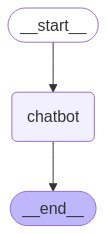

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: LangGraph is a Python library developed by LangChain that allows developers to create and manage complex AI workflows using a graph-based approach. It's designed to work with large language models (LLMs) and other AI components to create more sophisticated and flexible applications.

Key features and concepts of LangGraph include:

1. Graph-based Structure: It uses a graph structure to represent the flow of data and logic in AI applications, allowing for more complex and non-linear workflows.

2. Integration with LangChain: It's built to work seamlessly with LangChain, leveraging its components and utilities.

3. State Management: LangGraph provides tools for managing state across different steps in an AI workflow.

4. Flexible Execution: It allows for dynamic execution paths, making it easier to create applications that can adapt based on user input or intermediate results.

5. Reusability: Components and subgraphs can be easily reuse

### Tools

In [73]:
from langchain_tavily import TavilySearch

tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [77]:
tool.invoke(input={"query": "What happened at the last wimbledon"})

{'error': requests.exceptions.JSONDecodeError('Expecting value: line 1 column 1 (char 0)')}

### Event type 1: Comment created
We want to create a new thread using the Openai Assistant's SDK and start a run 

In [ ]:
from openai import OpenAI

client



### Event type 2: Comment updated
We want to check with openAI's assistant SDK to see if there is a thread available for this comment, based on the discussion ID. 